# Portfolio Optimization Using Python

This notebook addresses portfolio optimization, a strategy extensively applied by financial and investment advisors to ensure that their clients are maintaining the right balance of risk to realize their financial objectives.

The dataset for this project is simple and includes historical closing price information for a small stock portfolio, which was fetched from Investing.com.

The collected data is cleaned up to calculate the key metrics necessary to produce an optimal portfolio outcome. These are expected returns, expected volatility, and the Sharpe ratio. Once we have all these metrics calculated, we will create a `Monte Carlo simulation` that yields random outcomes, which will allow us to determine the best portfolio setup in relation to varied scenarios.

A plot of the result is then made using `matplotlib` to determine which portfolio is the best-performing investment strategy.

In [1]:
# Importing the libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Symbols of the stocks in the portfolio
SYMBOLS = ['AAPL' , 'AMZN' , 'MSFT']
NUM_OF_SYMBOLS = len(SYMBOLS)

# Load the data
price_data_frame: pd.DataFrame = pd.read_csv("../data/data.csv")
price_data_frame['date'] = pd.to_datetime(price_data_frame['date'], format='%d-%m-%Y')
display(price_data_frame.head())

,date,price,open,high,low,volume,symbol
0,2024-09-27,187.97,190.68,190.90,187.34,36.00M,AMZN
1,2024-09-26,191.16,194.31,194.53,189.54,36.33M,AMZN
2,2024-09-25,192.53,193.75,193.95,192.16,26.39M,AMZN
3,2024-09-24,193.96,194.27,195.37,190.13,43.48M,AMZN
4,2024-09-23,193.88,191.64,194.45,190.57,36.99M,AMZN


We can make use of the `pivot` method to reshape the data into separate columns for each symbol, each column of which contains the corresponding closing prices. Data structured like this will be easy for us to compute the daily returns of each stock.

In [3]:
# We need to pivot the data so that our index is the date, the columns are the symbols, and the values are the close prices.
price_data_frame = price_data_frame[['date', 'symbol', 'price']]

# Pivot the data
price_data_frame = price_data_frame.pivot_table(
    index='date',
    columns='symbol',
    values='price'
)
print(price_data_frame.head())

symbol        AAPL    AMZN    MSFT
date                              
2024-05-29  190.29  182.02  429.17
2024-05-30  191.29  179.32  414.67
2024-05-31  192.25  176.44  415.13
2024-06-03  194.03  178.34  413.52
2024-06-04  194.35  179.34  416.07


Notice here that we are getting returns off a portfolio of stocks, but in order to get those returns, we must necessarily take on risk—it just ideally happens in an acceptable form because we're actually getting returns that grow our investment.

Most investors, though, are not comfortable having high levels of risk. Our goal, therefore, is to find the best balance between risk and return. Ideally, we would like to have the highest level of risk we are comfortable with, while at the same time maximizing returns. This naturally leads to the question, "How do we measure risk?".

There are many ways to do this, and the appropriate method will often depend on the specific situation. In our case, we will make use of a particularly widely popular metric: the `Sharpe Ratio`. There is an industry standard for measuring risk-adjusted returns in that the Sharpe Ratio helps quantify the relationship between average return above the risk-free rate and the amount of volatility or total risk involved in earning that return.

Mathematically, we define the Sharpe Ratio as the following:

\begin{equation*}
\text{Sharpe Ratio} = \frac{(R_p - R_f)}{\sigma_p}
\end{equation*}

Where:

$
\begin{align}
\ R_p & = \text{Return of Portfolio} \\
\ R_f & = \text{Risk-Free Rate} \\
\ \sigma_p & = \text{Standard Deviation of Portfolio's Excess Return} \\
\end{align}
$

To calculate the expected returns, we use the following formula:

\begin{equation*}
\ R_p = (w_{1}r_{1}) + (w_{2}r_{2}) + \cdots + (w_{n}r_{n})
\end{equation*}

Where:

$
\begin{align}
\ r_{i} & = \text{Return of Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\end{align}
$

To calculate the standard deviation of the protfolio, we use the following formula:

\begin{equation*}
\ \sigma_p = \sqrt{(w_{i}^2 \sigma_i^2) + (w_{j}^2 \sigma_j^2) + (2w_{j}w_{i} p_{i,j} \sigma_i \sigma_j)}
\end{equation*}

Where:

$
\begin{align}
\ \sigma_{i} & = \text{Standard Deviation of Returns for Security i} \\
\ w_{i} & = \text{Weight of Security i} \\
\ p_{i,j} & = \text{Correlation Coefficent between the returns of asset i and asset j} \\
\end{align}
$

In [4]:
# Calculate the log returns
log_return = np.log(1 + price_data_frame.pct_change())

# Calculate the mean log returns
random_weights = np.array(np.random.random(NUM_OF_SYMBOLS))

# Normalize the random weights so that their sum equals 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Compute the annualized expected portfolio returns by multiplying by 252.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Compute the annualized expected portfolio volatility by multiplying by 252.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Display the results in a DataFrame.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})

# Display the weights DataFrame
print('Portfolio Weights:')
display(weights_df)

# Create a DataFrame to display the portfolio metrics
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

# Display the metrics DataFrame
print('Portfolio Metrics:')
display(metrics_df)

Portfolio Weights:


,random_weights,rebalance_weights
0,0.069037,0.058386
1,0.606179,0.512654
2,0.507218,0.428961


Portfolio Metrics:


,Expected Portfolio Returns,Expected Portfolio Volatility,Portfolio Sharpe Ratio
0,0.077523,0.230541,0.336266


# Portfolio Optimization: Monte Carlo

Having a way to measure how well our portfolio is allocated, we now need to calculate expected returns, expected volatility, and, using the Sharpe Ratio, analyze the risk-adjusted performance of the portfolio. The major question now is, "If we want to achieve a higher Sharpe Ratio, then what portfolio allocation do we need?"

There are two approaches to do this. The first one is to just test several random portfolio allocations and see which one has the highest Sharpe Ratio. The second one is mathematical optimization, where we try to find an optimal allocation that follows certain constraints. In the following section, we shall discuss the former approach: testing random allocations,which is popularly known as a Monte Carlo Simulation.

**Monte Carlo simulations model the probability of different outcomes in a process that might be influenced by random variables. It is the means of analyzing the impact of risk and uncertainty within a model of prediction and forecasting.**

We run the simulation a few thousand times, storing the result of each run in a data frame. Once the simulations are done, we identify the portfolio allocations with the highest Sharpe Ratio and the lowest volatility.

In [5]:
# Initialize the components for running a Monte Carlo Simulation.

# We will run 5000 iterations.
NUM_OF_ITERATIONS = 5000

# Create an array to store the weights of the stocks for all the 5000 iterations and all stocks in the portfolio.
all_weights = np.zeros((NUM_OF_ITERATIONS, NUM_OF_SYMBOLS))

# Prepare an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(NUM_OF_ITERATIONS)

# Prepare an array to store the volatility as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(NUM_OF_ITERATIONS)

# Prepare an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(NUM_OF_ITERATIONS)

# Start the Monte Carlo Simulation.
for ind in range(NUM_OF_ITERATIONS):

    # weight calculation
    weights = np.array(np.random.random(NUM_OF_SYMBOLS))
    weights = weights / np.sum(weights)

    # Save the weights in the `all_weights` array.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Display the results of the Monte Carlo Simulation.
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame to display the results of the Monte Carlo Simulation.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('SIMULATIONS RESULT:')
display(simulations_df.head())

SIMULATIONS RESULT:


,Returns,Volatility,Sharpe Ratio,Portfolio Weights
0,0.246026,0.210564,1.168413,"[0.3985728587806986, 0.3423062754695161, 0.259..."
1,0.264969,0.199395,1.328864,"[0.47334234792568664, 0.13181692514933482, 0.3..."
2,0.236167,0.198119,1.192043,"[0.4139159058651249, 0.1676304237264133, 0.418..."
3,0.106094,0.229336,0.462613,"[0.10971236027881946, 0.5170590678704529, 0.37..."
4,0.065308,0.200044,0.326467,"[0.0952805977511704, 0.20253522820007253, 0.70..."


# Grab the Important Metrics
Now that we've run our simulation, let's get a closer look at some key metrics.

There's max_sharpe_ratio, which is the Sharpe Ratio where the excess return of the portfolio is highest relative to the risk being taken.That's another way of saying these portfolios are really "best" because they produce the highest possible risk-adjusted returns. 

The second metric is the one called min_volatility. It shows the portfolio weights resulting in the lowest overall volatility. In other words, if it wants to bear the minimum amount of risk, these are the weights it should target.

In [6]:
# Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

# Display the results.

print("Max Sharpe Ratio:")
display(max_sharpe_ratio)

print("Min Volatility:")
display(min_volatility)

Max Sharpe Ratio:


Returns                                                       0.511901
Volatility                                                    0.246479
Sharpe Ratio                                                  2.076856
Portfolio Weights    [0.9441134039691105, 0.02758173661533885, 0.02...
Name: 1536, dtype: object

Min Volatility:


Returns                                                       0.143321
Volatility                                                    0.190615
Sharpe Ratio                                                  0.751888
Portfolio Weights    [0.27565908124242045, 0.0038155546214753942, 0...
Name: 1672, dtype: object

# Plotting:

Making different portfolio weights is helpful, but visualizing the output from our simulation by a graph gives a much clearer view. We'll use matplotlib to make a scatter plot illustrating the relationship between the overall volatility of a portfolio and its expected returns. Ideally, we must see that as we take more in terms of risk, the risk-adjusted returns are better. Conversely, lower volatility should reflect to fairly lower returns.

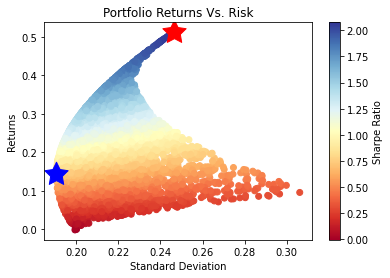

In [8]:
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# A red star will represent the Max Sharpe Ratio.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# A blue star will represent the Min Volatility.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Display the plot.
plt.show()